In [200]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import mplfinance as mpf
from tensorflow import keras
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# OLD STUFF

In [285]:
stock_name = "AZN"

In [297]:
def prepare_data(stock_name, period="5y", interval="1d", with_today=False,back_time=5):

    recent_data = yf.download(stock_name, period=period, interval=interval)
    data_200 = yf.download(stock_name, period="5y", interval="1d").tail(len(recent_data) + 200)
    data_200 = data_200.drop(columns=["Adj Close"])

    data_200["last_close"] = data_200["Close"].shift(1)
    data_200.fillna(method="bfill", inplace=True)

    data_200["movement"] = data_200["Close"] - data_200["Open"]

    data_200["200_day"] = data_200["Close"].rolling(window=200).mean()

    recent_data = data_200.tail(len(recent_data))
    if not with_today:
        recent_data = recent_data.iloc[:-1]

    for i in range(back_time):
        recent_data[f"Open t - {i+1}"] = recent_data["Open"].shift(-(i+1))
        recent_data[f"Close t - {i+1}"] = recent_data["Close"].shift(-(i+1))
        recent_data[f"High t - {i+1}"] = recent_data["High"].shift(-(i+1))
        recent_data[f"Low t - {i+1}"] = recent_data["Low"].shift(-(i+1))
    recent_data = recent_data.dropna()
    # add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    return recent_data

prepare_data(stock_name, "1y")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\USER\AppData\Local\Temp\ipykernel_29064\146692530.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)


,Open,High,Low,Close,Volume,last_close,movement,200_day,Open t - 1,Close t - 1,...,High t - 3,Low t - 3,Open t - 4,Close t - 4,High t - 4,Low t - 4,Open t - 5,Close t - 5,High t - 5,Low t - 5
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-09,70.889999,71.559998,70.830002,71.279999,4324200,70.480003,0.389999,68.75720,71.040001,70.339996,...,70.910004,69.940002,69.940002,69.510002,70.120003,69.339996,68.949997,69.709999,70.029999,68.919998
2023-08-10,71.040001,71.510002,70.330002,70.339996,3876600,71.279999,-0.700005,68.83405,69.699997,70.370003,...,70.120003,69.339996,68.949997,69.709999,70.029999,68.919998,69.239998,69.120003,69.769997,69.120003
2023-08-11,69.699997,70.580002,69.540001,70.370003,3549700,70.339996,0.670006,68.91000,70.029999,70.839996,...,70.029999,68.919998,69.239998,69.120003,69.769997,69.120003,68.370003,68.459999,68.779999,68.099998
2023-08-14,70.029999,70.910004,69.940002,70.839996,3843100,70.370003,0.809998,68.98470,69.940002,69.510002,...,69.769997,69.120003,68.370003,68.459999,68.779999,68.099998,68.980003,68.879997,69.139999,68.519997
2023-08-15,69.940002,70.120003,69.339996,69.510002,4243800,70.839996,-0.430000,69.04245,68.949997,69.709999,...,68.779999,68.099998,68.980003,68.879997,69.139999,68.519997,68.809998,68.769997,68.970001,68.389999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,78.480003,79.449997,78.080002,78.129997,5878400,78.519997,-0.350006,69.79240,80.059998,78.360001,...,79.559998,78.529999,79.650002,81.199997,81.400002,79.620003,81.599998,81.809998,82.010002,80.830002
2024-07-29,80.059998,80.120003,78.330002,78.360001,6753900,78.129997,-1.699997,69.84415,78.699997,77.900002,...,81.400002,79.620003,81.599998,81.809998,82.010002,80.830002,78.879997,79.330002,80.129997,78.690002
2024-07-30,78.699997,78.989998,77.470001,77.900002,6480800,78.360001,-0.799995,69.89360,79.129997,79.150002,...,82.010002,80.830002,78.879997,79.330002,80.129997,78.690002,78.250000,79.250000,79.730003,78.220001


In [298]:
recent_data = prepare_data(stock_name, "1y")
recent_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\USER\AppData\Local\Temp\ipykernel_29064\146692530.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)


,Open,High,Low,Close,Volume,last_close,movement,200_day,Open t - 1,Close t - 1,...,High t - 3,Low t - 3,Open t - 4,Close t - 4,High t - 4,Low t - 4,Open t - 5,Close t - 5,High t - 5,Low t - 5
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-09,70.889999,71.559998,70.830002,71.279999,4324200,70.480003,0.389999,68.75720,71.040001,70.339996,...,70.910004,69.940002,69.940002,69.510002,70.120003,69.339996,68.949997,69.709999,70.029999,68.919998
2023-08-10,71.040001,71.510002,70.330002,70.339996,3876600,71.279999,-0.700005,68.83405,69.699997,70.370003,...,70.120003,69.339996,68.949997,69.709999,70.029999,68.919998,69.239998,69.120003,69.769997,69.120003
2023-08-11,69.699997,70.580002,69.540001,70.370003,3549700,70.339996,0.670006,68.91000,70.029999,70.839996,...,70.029999,68.919998,69.239998,69.120003,69.769997,69.120003,68.370003,68.459999,68.779999,68.099998
2023-08-14,70.029999,70.910004,69.940002,70.839996,3843100,70.370003,0.809998,68.98470,69.940002,69.510002,...,69.769997,69.120003,68.370003,68.459999,68.779999,68.099998,68.980003,68.879997,69.139999,68.519997
2023-08-15,69.940002,70.120003,69.339996,69.510002,4243800,70.839996,-0.430000,69.04245,68.949997,69.709999,...,68.779999,68.099998,68.980003,68.879997,69.139999,68.519997,68.809998,68.769997,68.970001,68.389999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,78.480003,79.449997,78.080002,78.129997,5878400,78.519997,-0.350006,69.79240,80.059998,78.360001,...,79.559998,78.529999,79.650002,81.199997,81.400002,79.620003,81.599998,81.809998,82.010002,80.830002
2024-07-29,80.059998,80.120003,78.330002,78.360001,6753900,78.129997,-1.699997,69.84415,78.699997,77.900002,...,81.400002,79.620003,81.599998,81.809998,82.010002,80.830002,78.879997,79.330002,80.129997,78.690002
2024-07-30,78.699997,78.989998,77.470001,77.900002,6480800,78.360001,-0.799995,69.89360,79.129997,79.150002,...,82.010002,80.830002,78.879997,79.330002,80.129997,78.690002,78.250000,79.250000,79.730003,78.220001


In [299]:
X = recent_data.drop(columns=["Close", "movement","Volume"])
print(X)
y = recent_data["movement"]

train_X,val_X,train_y,val_y = train_test_split(X,y,random_state = 1)

input_shape = [5]



early_stopping = callbacks.EarlyStopping(

    min_delta=0.0001, # minimium amount of change to count as an improvement

    patience=40, # how many epochs to wait before stopping

    restore_best_weights=True,
)



model = keras.Sequential(
    [

        layers.Dense(128, activation="relu", input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),

        layers.Dense(1),

    ]
)



optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(


    optimizer=optimizer,
    loss="mse",
)
EPOCHS = 100
history = model.fit(

    train_X, train_y,

    validation_data=(val_X, val_y),

    batch_size=64,

    epochs=EPOCHS,

    callbacks=[early_stopping],

    verbose=0,
    
)

                 Open       High        Low  last_close   200_day  Open t - 1  \
Date                                                                            
2023-08-09  70.889999  71.559998  70.830002   70.480003  68.75720   71.040001   
2023-08-10  71.040001  71.510002  70.330002   71.279999  68.83405   69.699997   
2023-08-11  69.699997  70.580002  69.540001   70.339996  68.91000   70.029999   
2023-08-14  70.029999  70.910004  69.940002   70.370003  68.98470   69.940002   
2023-08-15  69.940002  70.120003  69.339996   70.839996  69.04245   68.949997   
...               ...        ...        ...         ...       ...         ...   
2024-07-26  78.480003  79.449997  78.080002   78.519997  69.79240   80.059998   
2024-07-29  80.059998  80.120003  78.330002   78.129997  69.84415   78.699997   
2024-07-30  78.699997  78.989998  77.470001   78.360001  69.89360   79.129997   
2024-07-31  79.129997  79.559998  78.529999   77.900002  69.94880   79.650002   
2024-08-01  79.650002  81.40

NameError: name 'callbacks' is not defined

In [8]:
check_data = prepare_data(stock_name, "5d", "1d", True)

print(check_data)
check_X = check_data.drop(columns=["Close","Volume", "movement"])
# print(checl_data.head())
print(check_X.tail(1))

print(model.predict(check_X.tail(1)))
print(check_X.tail(1).Open[0] + model.predict(check_X.tail(1))[0])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low  last_close   200_day
Date                                                                
2024-08-07  206.899994  213.639999  206.389999  207.229996  190.0109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0.01630338]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[206.91629]



C:\Users\USER\AppData\Local\Temp\ipykernel_19432\2875853402.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_19432\62514165.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(check_X.tail(1).Open[0] + model.predict(check_X.tail(1))[0])


Minimum validation loss: 0.35956647992134094


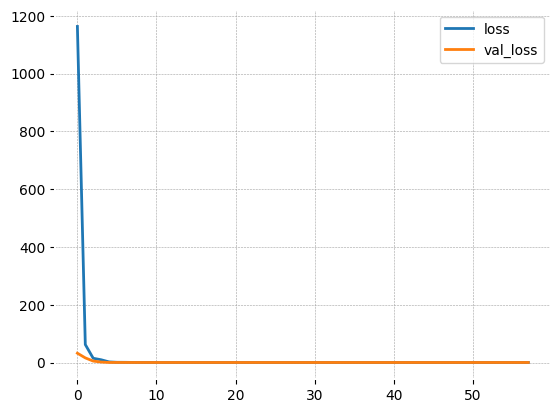

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [9]:
recent_data.head()


,Open,High,Low,Close,Volume,last_close,movement,200_day
Date,,,,,,,,
2023-08-09,180.869995,180.929993,177.009995,178.190002,60378500,179.800003,-2.679993,160.5426
2023-08-10,179.479996,180.750000,177.600006,177.970001,54686900,178.190002,-1.509995,160.6961
2023-08-11,177.320007,178.619995,176.550003,177.789993,51988100,177.970001,0.469986,160.8378
2023-08-14,177.970001,179.690002,177.309998,179.460007,43675600,177.789993,1.490005,160.9734
2023-08-15,178.880005,179.479996,177.050003,177.449997,43622600,179.460007,-1.430008,161.1139


# NEW THINGS

In [204]:
stock_name = "AAPL"

In [205]:
def prepare_data(stock_name, period="5d", interval="1m",back_time=5):

    recent_data = yf.download(stock_name, period=period, interval=interval)
    data_200 = yf.download(stock_name, period=period, interval=interval).tail(len(recent_data) + 200)
    data_200 = data_200.drop(columns=["Adj Close"])

    data_200.fillna(method="bfill", inplace=True)

   # recent_data = data_200.tail(len(recent_data))

    recent_data = recent_data.iloc[:-1]

    for i in range(back_time):
        recent_data[f"Open t - {i+1}"] = recent_data["Open"].shift((i+1))
        recent_data[f"Close t - {i+1}"] = recent_data["Close"].shift((i+1))
        recent_data[f"High t - {i+1}"] = recent_data["High"].shift((i+1))
        recent_data[f"Low t - {i+1}"] = recent_data["Low"].shift((i+1))
    recent_data = recent_data.dropna()

       
    # add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    return recent_data

recent_data = prepare_data(stock_name,back_time=10,period="5d",interval="1m")

recent_data.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Open t - 1,Close t - 1,High t - 1,Low t - 1,...,High t - 8,Low t - 8,Open t - 9,Close t - 9,High t - 9,Low t - 9,Open t - 10,Close t - 10,High t - 10,Low t - 10
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-08-05 09:40:00-04:00,209.184998,210.000000,208.869400,208.979996,208.979996,993499,207.800003,209.235001,209.300003,207.679993,...,204.759995,202.503998,198.949997,202.539993,202.600006,198.279999,199.139999,197.660004,199.139999,196.210007
2024-08-05 09:41:00-04:00,209.000000,209.509995,207.544998,207.669998,207.669998,878502,209.184998,208.979996,210.000000,208.869400,...,206.139999,203.750000,202.563995,204.350006,204.759995,202.503998,198.949997,202.539993,202.600006,198.279999
2024-08-05 09:42:00-04:00,207.645004,208.990005,207.500000,208.619995,208.619995,579552,209.000000,207.669998,209.509995,207.544998,...,206.779999,205.009995,204.339996,205.899994,206.139999,203.750000,202.563995,204.350006,204.759995,202.503998
2024-08-05 09:43:00-04:00,208.649994,209.580002,207.919998,208.020004,208.020004,608393,207.645004,208.619995,208.990005,207.500000,...,206.940002,204.190002,205.899994,205.610001,206.779999,205.009995,204.339996,205.899994,206.139999,203.750000
2024-08-05 09:44:00-04:00,208.032303,208.690002,207.440796,208.550003,208.550003,547275,208.649994,208.020004,209.580002,207.919998,...,206.139999,204.589996,205.687897,204.710007,206.940002,204.190002,205.899994,205.610001,206.779999,205.009995


In [206]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn

X = recent_data.drop(["Close", "Volume", "High", "Low"], axis=1)
y = recent_data[["Close", "High", "Low"]]

X_tensor = torch.from_numpy(X.values)
y_tensor = torch.from_numpy(y.values)


X_train,X_test,y_train,y_test = train_test_split(X_tensor,y_tensor,test_size=0.2)
X_train = X_train.to(torch.float32)
X_test= X_test.to(torch.float32)
y_train = y_train.to(torch.float32)
y_test =y_test.to(torch.float32)

In [207]:
input_shape = X.shape[1]


class StockEstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_shape,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=5),
        
            nn.Linear(in_features=5,out_features=3)
        )
    
    def forward(self,x):
        
        return self.layers(x)
model = StockEstModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
print(X_train.dtype)

torch.float32


In [211]:
epochs = 100000



for epoch in range(epochs):
    model.train()

    y_pred = model(X_train)
    loss = loss_fn(y_pred,y_train)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred,y_test)
        if epoch%10000==0:
            print(f"epoch: {epoch} loss = {loss}, test loss = {test_loss}")

epoch: 0 loss = 0.3136681914329529, test loss = 0.27989670634269714
epoch: 1000 loss = 0.30024954676628113, test loss = 0.26802119612693787
epoch: 2000 loss = 0.28880077600479126, test loss = 0.25798916816711426
epoch: 3000 loss = 0.27913036942481995, test loss = 0.24951496720314026
epoch: 4000 loss = 0.2708056569099426, test loss = 0.24222572147846222
epoch: 5000 loss = 0.2633821964263916, test loss = 0.23573027551174164
epoch: 6000 loss = 0.27821338176727295, test loss = 0.26175782084465027
epoch: 7000 loss = 0.2628178298473358, test loss = 0.23623539507389069
epoch: 8000 loss = 0.2459930181503296, test loss = 0.22076192498207092
epoch: 9000 loss = 0.2402564287185669, test loss = 0.21579094231128693


In [36]:
torch.save(model, "model1.pt")

In [184]:
def prepare_test_data(stock_name, period="1y", interval="1d",back_time=5):

    recent_data = yf.download(stock_name, period=period, interval=interval)
    data_200 = yf.download(stock_name, period=period, interval=interval).tail(len(recent_data) + 200)
    data_200 = data_200.drop(columns=["Adj Close"])

    data_200.fillna(method="bfill", inplace=True)

    recent_data = data_200.tail(len(recent_data))


    for i in range(back_time):
        recent_data[f"Open t - {i+1}"] = recent_data["Open"].shift((i+1))
        recent_data[f"Close t - {i+1}"] = recent_data["Close"].shift((i+1))
        recent_data[f"High t - {i+1}"] = recent_data["High"].shift((i+1))
        recent_data[f"Low t - {i+1}"] = recent_data["Low"].shift((i+1))
    recent_data = recent_data.dropna()

       
    # add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    return recent_data

recent_data = prepare_test_data(stock_name,back_time=10)

recent_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\USER\AppData\Local\Temp\ipykernel_3740\2711691039.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)


,Open,High,Low,Close,Volume,Open t - 1,Close t - 1,High t - 1,Low t - 1,Open t - 2,...,High t - 8,Low t - 8,Open t - 9,Close t - 9,High t - 9,Low t - 9,Open t - 10,Close t - 10,High t - 10,Low t - 10
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-24,180.669998,181.100006,176.009995,176.380005,54945800,178.520004,181.119995,181.550003,178.330002,177.059998,...,179.690002,177.309998,177.320007,177.789993,178.619995,176.550003,179.479996,177.970001,180.750000,177.600006
2023-08-25,177.380005,179.149994,175.820007,178.610001,51449600,180.669998,176.380005,181.100006,176.009995,178.520004,...,179.479996,177.050003,177.970001,179.460007,179.690002,177.309998,177.320007,177.789993,178.619995,176.550003
2023-08-28,180.089996,180.589996,178.550003,180.190002,43820700,177.380005,178.610001,179.149994,175.820007,180.669998,...,178.539993,176.500000,178.880005,177.449997,179.479996,177.050003,177.970001,179.460007,179.690002,177.309998
2023-08-29,179.699997,184.899994,179.500000,184.119995,53003900,180.089996,180.190002,180.589996,178.550003,177.380005,...,177.509995,173.479996,177.130005,176.570007,178.539993,176.500000,178.880005,177.449997,179.479996,177.050003
2023-08-30,184.940002,187.850006,184.740005,187.649994,60813900,179.699997,184.119995,184.899994,179.500000,180.089996,...,175.100006,171.960007,177.139999,174.000000,177.509995,173.479996,177.130005,176.570007,178.539993,176.500000


In [212]:
def prepare_test_loop_data(stock_name, period="5d", interval="1m",back_time=5, answers =[]):

    recent_data = yf.download(stock_name, period=period, interval=interval)
    for i in answers:
        df =  pd.DataFrame({'Close': [i[0]], "High":[i[1]],'Low': [i[2]],"Open":[i[3]],"Adj Close":[0],"Volume":[0]})

        recent_data = recent_data._append(df,ignore_index=True)

    data_200 = yf.download(stock_name, period=period, interval=interval).tail(len(recent_data) + 201)
    data_200 = data_200.drop(columns=["Adj Close"])

    data_200.fillna(method="bfill", inplace=True)

    #recent_data = data_200.tail(len(recent_data))


    for i in range(back_time):
        recent_data[f"Open t - {i+1}"] = recent_data["Open"].shift((i+1))
        recent_data[f"Close t - {i+1}"] = recent_data["Close"].shift((i+1))
        recent_data[f"High t - {i+1}"] = recent_data["High"].shift((i+1))
        recent_data[f"Low t - {i+1}"] = recent_data["Low"].shift((i+1))
    recent_data = recent_data.dropna()

    recent_data = recent_data.tail(1)
    # add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    return recent_data

recent_data = prepare_test_loop_data(stock_name,back_time=1,answers=[answer])
recent_data.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Open t - 1,Close t - 1,High t - 1,Low t - 1
1947,189.496429,188.79332,188.537872,188.693146,0.0,0,216.289993,216.300003,216.399994,216.119995


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

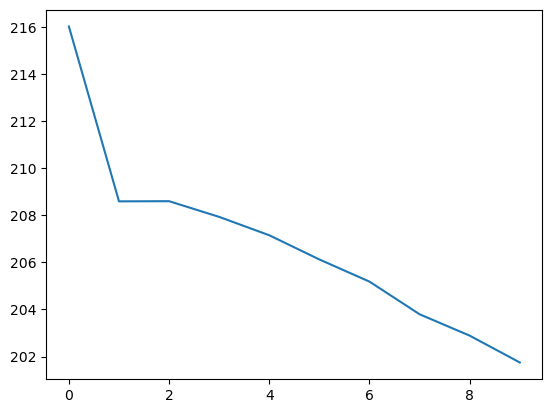

In [214]:
import numpy as np
import matplotlib.pyplot as plt
answers = []
forcast = 10
for i in range(forcast):
    check_data = prepare_test_loop_data(
        interval="1m", back_time=10, period="5d", stock_name=stock_name,answers=answers
    )
    check_data = check_data.iloc[[-1]]
    check_X = check_data.drop(["Close", "Volume", "High", "Low"], axis=1)
    check_y = check_data[["Close", "High", "Low"]]

    # print(check_data.to_markdown())
    # print(X.shape)

    check_X_tensor = torch.from_numpy(check_X.values)
    check_y_tensor = torch.from_numpy(check_y.values)

    check_X_tensor = check_X_tensor.to(torch.float32)
    check_y_tensor = check_y_tensor.to(torch.float32)

    answer = model(check_X_tensor)
    answer = answer.detach().cpu().numpy()

    answer = np.append(answer[0],check_X["Close t - 1"])
    answers.append(answer)

#sns.catplot(answer[0][:],label="Predicted")
last_elements = [arr[0] for arr in answers]
plt.plot(last_elements)